# Monitorización de equipos industriales para detección de fallos


### 1. Importación de librerias

In [508]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
from imblearn.over_sampling import SMOTE

### 2. Carga del csv

In [509]:
df = pd.read_csv("equipment_anomaly_data.csv")
df.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.180180,25.029278,0.606516,45.694907,Turbine,Atlanta,0.0
1,75.740712,22.954018,2.338095,41.867407,Compressor,Chicago,0.0
2,71.358594,27.276830,1.389198,58.954409,Turbine,San Francisco,0.0
3,71.616985,32.242921,1.770690,40.565138,Pump,Atlanta,0.0
4,66.506832,45.197471,0.345398,43.253795,Pump,New York,0.0


### 3. Detección de anomalías

In [510]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7672 non-null   float64
 1   pressure     7672 non-null   float64
 2   vibration    7672 non-null   float64
 3   humidity     7672 non-null   float64
 4   equipment    7672 non-null   object 
 5   location     7672 non-null   object 
 6   faulty       7672 non-null   float64
dtypes: float64(5), object(2)
memory usage: 419.7+ KB


In [511]:
df.describe()

,temperature,pressure,vibration,humidity,faulty
count,7672.000000,7672.000000,7672.000000,7672.000000,7672.000000
mean,70.922478,35.738048,1.611809,50.016574,0.099974
std,16.200059,10.381593,0.728560,11.841479,0.299985
min,10.269385,3.620798,-0.428188,10.215077,0.000000
25%,62.777057,29.485682,1.170906,42.612817,0.000000
50%,70.156900,35.227544,1.533113,50.024744,0.000000
75%,77.568387,41.159913,1.924700,57.340513,0.000000
max,149.690420,79.887734,4.990537,89.984718,1.000000


In [512]:
df.isnull().sum()

temperature    0
pressure       0
vibration      0
humidity       0
equipment      0
location       0
faulty         0
dtype: int64

In [513]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
7667    False
7668    False
7669    False
7670    False
7671    False
Length: 7672, dtype: bool

In [514]:
df.columns

Index(['temperature', 'pressure', 'vibration', 'humidity', 'equipment',
       'location', 'faulty'],
      dtype='object')

### 4. Visualización de datos

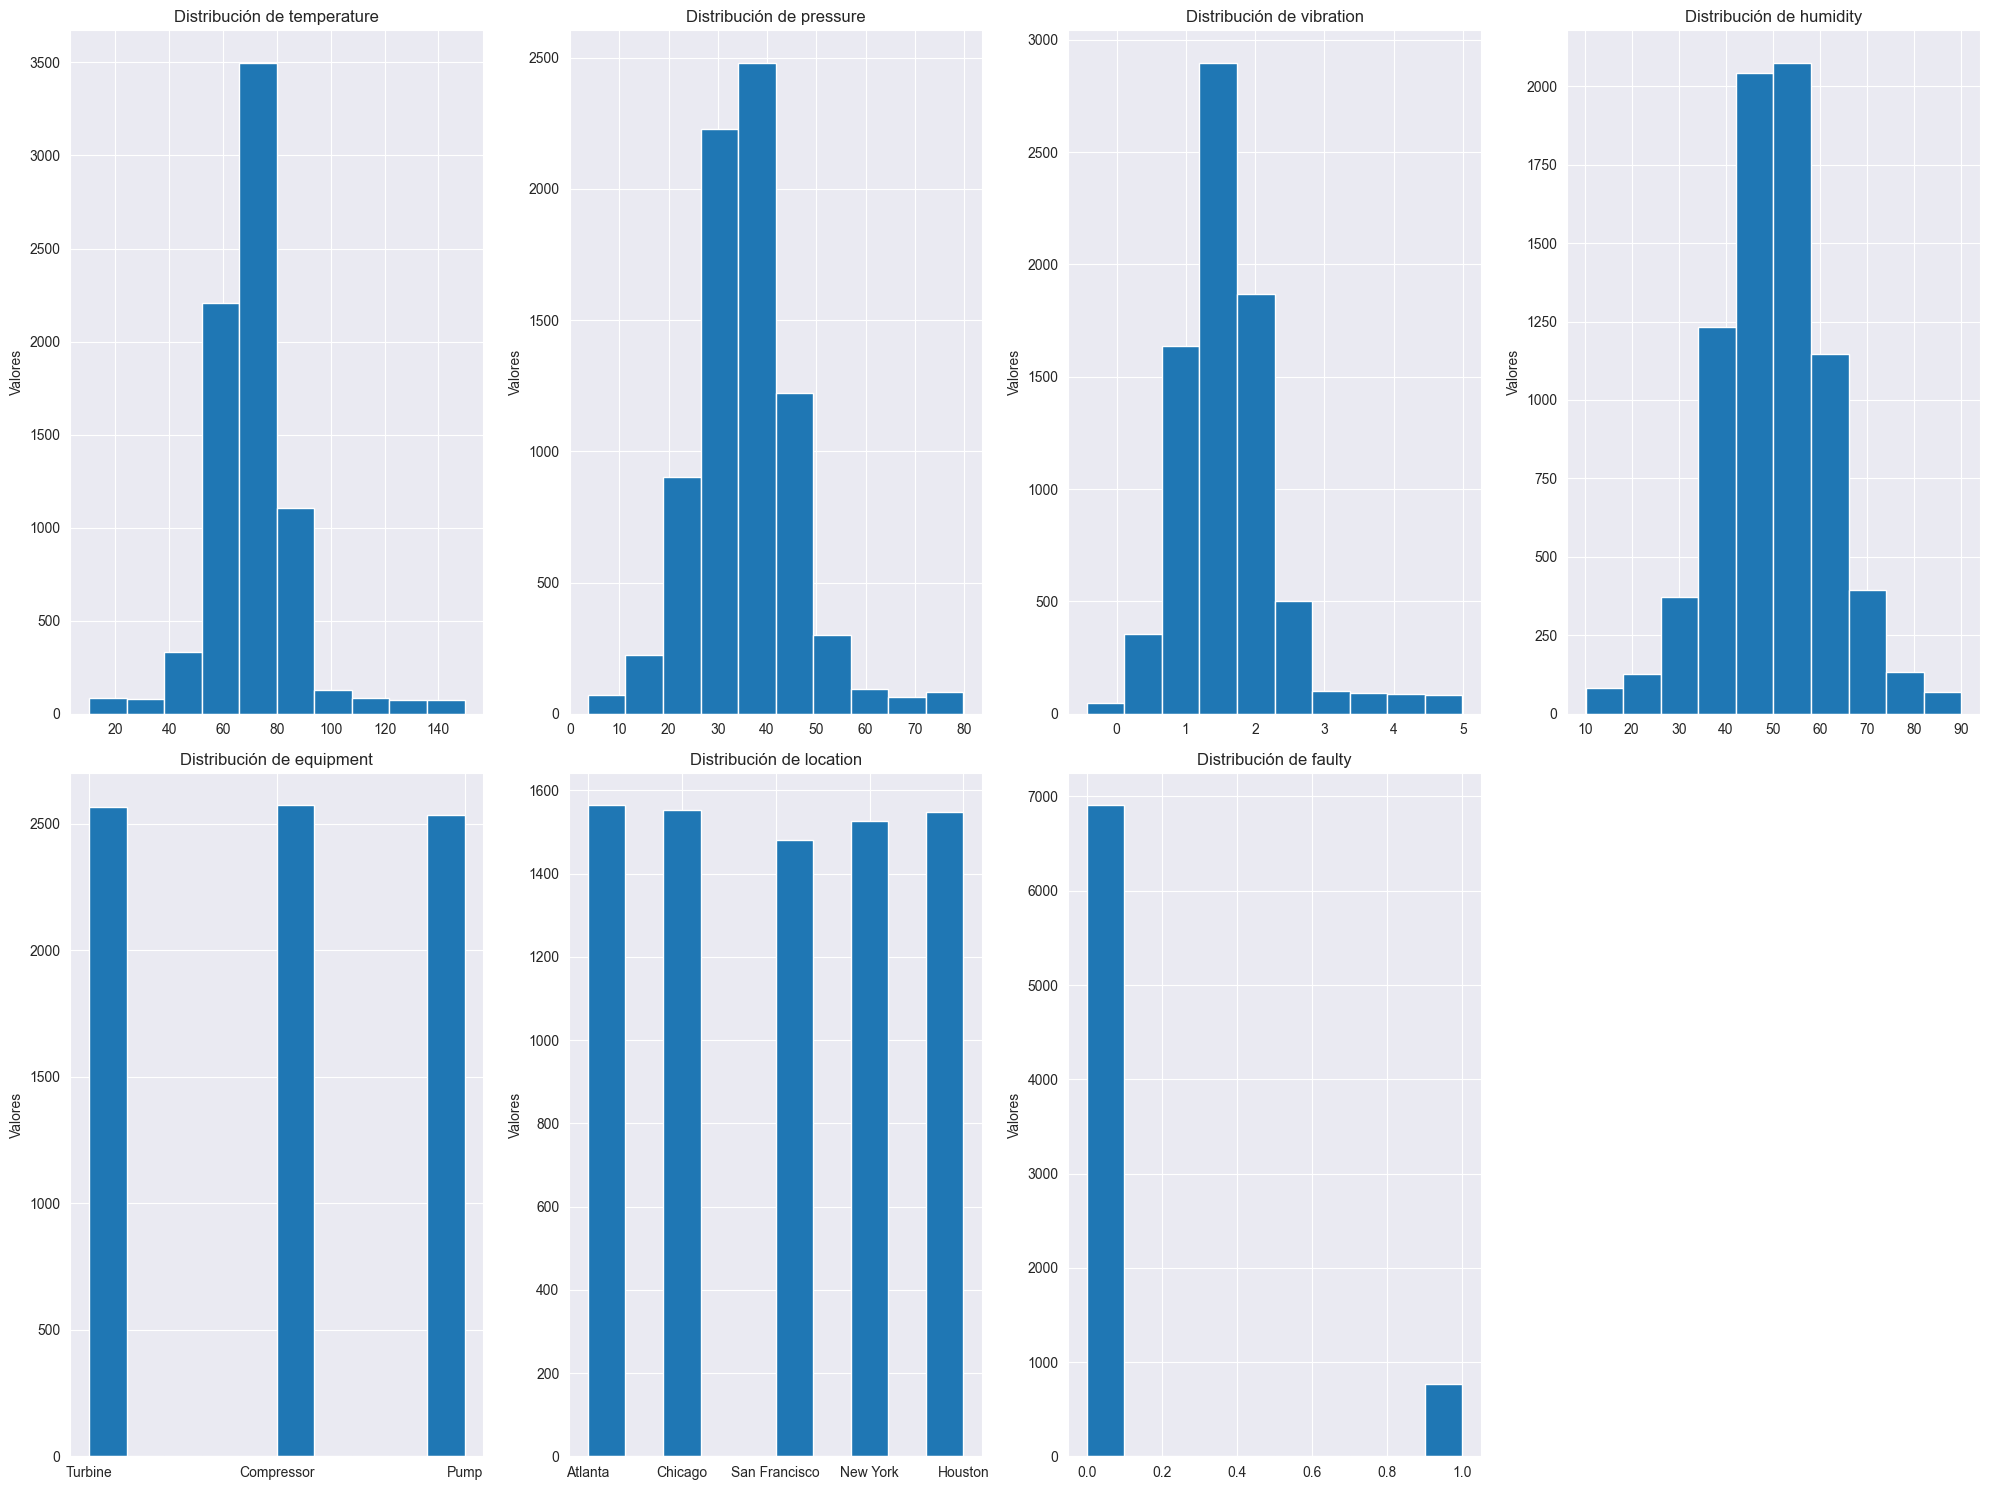

In [515]:
categorias = ['temperature', 'pressure', 'vibration', 'humidity', 'equipment','location', 'faulty']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 15))
axes = axes.flatten()
for i, var in enumerate(categorias):
 axes[i].hist(df[var])
 axes[i].set_title(f'Distribución de {var}')
 axes[i].set_ylabel('Valores')
for j in range(len(categorias), len(axes)):
 axes[j].axis('off')
plt.tight_layout()
plt.show()

In [516]:
df['equipment'].value_counts()

equipment
Compressor    2573
Turbine       2565
Pump          2534
Name: count, dtype: int64

In [517]:
df['location'].value_counts()

location
Atlanta          1564
Chicago          1553
Houston          1548
New York         1526
San Francisco    1481
Name: count, dtype: int64

In [518]:
df['faulty'].value_counts()

faulty
0.0    6905
1.0     767
Name: count, dtype: int64

De acuerdo con la ingeniería de características realizaremos `OneHotEncoder` para `equipment` y para `location`, en el caso de `faulty` necesitaremos realizar resample porque hay demasiados defectuosos en comparación con los que no

### 5. Ingeniería de características

In [519]:
# Instanciar OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Crea un array en vez de una matriz

# Aplicar el encoder a las columnas categóricas
categoricas = ['location', 'equipment']
valores = encoder.fit_transform(df[categoricas])

# Crear un DataFrame con los valores codificados
columnas_codificadas = encoder.get_feature_names_out(categoricas)
df_codificado = pd.DataFrame(valores, columns=columnas_codificadas, index=df.index)

# Concatenar el DataFrame original con las columnas codificadas
df = pd.concat([df.drop(columns=categoricas, axis=1), df_codificado], axis=1)

In [520]:
df.head()

,temperature,pressure,vibration,humidity,faulty,location_Atlanta,location_Chicago,location_Houston,location_New York,location_San Francisco,equipment_Compressor,equipment_Pump,equipment_Turbine
0,58.180180,25.029278,0.606516,45.694907,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,75.740712,22.954018,2.338095,41.867407,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,71.358594,27.276830,1.389198,58.954409,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,71.616985,32.242921,1.770690,40.565138,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,66.506832,45.197471,0.345398,43.253795,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [521]:
df.shape

(7672, 13)

In [522]:
# # Nos interesan los cuartiles del 25% y 75%
# categorias = ['temperature', 'pressure', 'vibration', 'humidity']
# Q1, Q3 = np.percentile(df['temperature'], [25, 75])
# IQR = Q3 - Q1
# outliers = []
# for elemento in df['temperature']:
#  if elemento < (Q1 - 1.5 * IQR) or elemento > (Q3 + 1.5 * IQR):
#   outliers.append(elemento)
# outliers

In [523]:
# df = df[~df['temperature'].isin(outliers)]
# df.shape

In [524]:
# Q1, Q3 = np.percentile(df['pressure'], [25, 75])
# IQR = Q3 - Q1
# outliers2 = []
# for elemento in df['pressure']:
#  if elemento < (Q1 - 1.5 * IQR) or elemento > (Q3 + 1.5 * IQR):
#   outliers2.append(elemento)
# outliers2

In [525]:
# df = df[~df['pressure'].isin(outliers2)]
# df.shape

In [526]:
# Q1, Q3 = np.percentile(df['vibration'], [25, 75])
# IQR = Q3 - Q1
# outliers2 = []
# for elemento in df['vibration']:
#  if elemento < (Q1 - 1.5 * IQR) or elemento > (Q3 + 1.5 * IQR):
#   outliers2.append(elemento)
# outliers2

In [527]:
# df = df[~df['vibration'].isin(outliers2)]
# df.shape

In [528]:
# Q1, Q3 = np.percentile(df['humidity'], [25, 75])
# IQR = Q3 - Q1
# outliers2 = []
# for elemento in df['humidity']:
#  if elemento < (Q1 - 1.5 * IQR) or elemento > (Q3 + 1.5 * IQR):
#   outliers2.append(elemento)
# outliers2

In [529]:
# df = df[~df['humidity'].isin(outliers2)]
# df.shape

Aplicando el rango intercuartílico hemos eliminado los outliers de las variables numericas, pero si recordamos la visaulización del prinicpio hemos visto que la variable objetivo tiene muchos datos de la clase 0 y muy pocos de la 1, vamos a reajustar este inconveniente

In [530]:
# # Supongamos que separamos clases mayoritaria y minoritaria
# df_major = df[df['faulty'] == 0]
# df_minor = df[df['faulty'] == 1]
# # Ahora hacemos oversampling de la clase minoritaria
# df_minor_oversampled = resample(df_minor,
# replace=True,n_samples=len(df_major), random_state=42)
# # Combinar las clases
# df_balanced = pd.concat([df_major, df_minor_oversampled])

In [531]:
# plt.hist(df_balanced['faulty'])

Después de aplicar `resample` se puede apreciar que las clases están equilibradas, a continuación se procederá al entrenamiento del modelo

### 6. Entrenamiento del modelo

Primero se escalará el dataframe ya que es de obligado cumplimiento para una red neuronal a diferencia de cualquier modelo de ML

In [532]:
X = df.drop('faulty',axis=1)
y = df['faulty']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Creamos la red neuronal con 3 capas ocultas, todas de activación `relu` y un `Dropout` del 0.5 y 0.3 respectivamente por la reducción de capas ocultas a medida que el entrenamiento avanza

In [533]:
# Creamos el modelo de red neuronal
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model = Sequential([
 Input(shape=(X_train.shape[1],)), # Definir forma de la entrada
    Dense(32, activation='relu'), # 1a capa oculta
    Dropout(0.5),
    Dense(16, activation='relu'), # 1a capa oculta
    Dropout(0.3),
    Dense(8, activation='relu'), # 2a capa oculta
    Dense(1, activation='sigmoid') # Salida
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# Mostramos configuración
model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_96 (Dense)                │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,089 (4.25 KB)

 Trainable params: 1,089 (4.25 KB)

 Non-trainable params: 0 (0.00 B)

In [534]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8758 - loss: 0.4721 - val_accuracy: 0.8974 - val_loss: 0.3076
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9083 - loss: 0.3464 - val_accuracy: 0.9129 - val_loss: 0.2595
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9093 - loss: 0.3322 - val_accuracy: 0.9292 - val_loss: 0.2253
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9208 - loss: 0.2794 - val_accuracy: 0.9454 - val_loss: 0.1943
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9291 - loss: 0.2524 - val_accuracy: 0.9528 - val_loss: 0.1677
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9337 - loss: 0.2388 - val_accuracy: 0.9560 - val_loss: 0.1496
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9401 - loss: 0.2095 - val_accuracy: 0.9593 - val_loss: 0.1397
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9445 - loss: 0.2012 - val_accuracy: 0.

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9813 - loss: 0.0738
Pérdida: 0.08131590485572815, Precisión: 0.9791530966758728


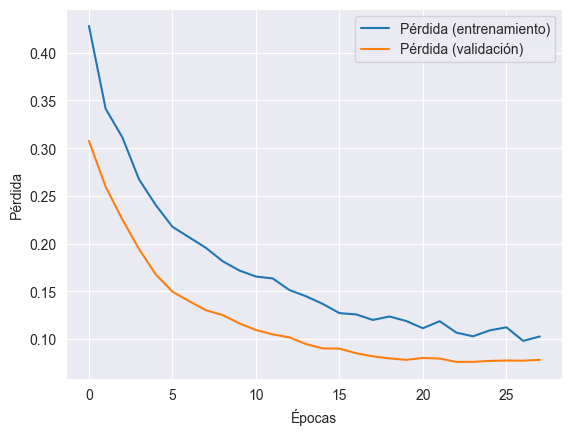

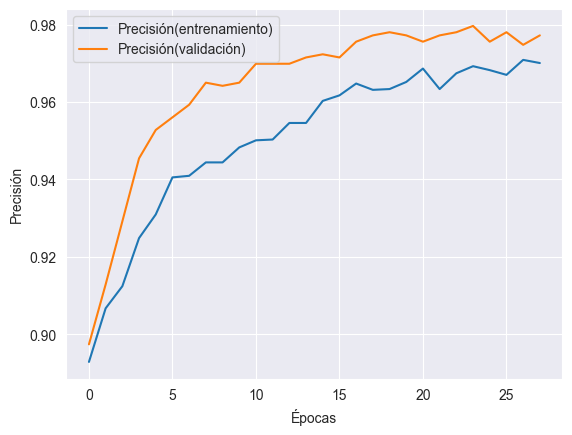

In [535]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida: {loss}, Precisión: {accuracy}")
# Pérdida
plt.plot(history.history['loss'], label='Pérdida (entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (validación)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
# Precisión
plt.plot(history.history['accuracy'], label='Precisión(entrenamiento)')
plt.plot(history.history['val_accuracy'], label='Precisión(validación)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

A primera vista de las gráficas se puede apreciar un claro overfitting del modelo, en el cuál no se distingue en absoluto una mejoría

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Reporte de Clasificación:
                  precision    recall  f1-score   support

No Mantenimiento       0.98      1.00      0.99      1377
   Mantenimiento       0.98      0.81      0.89       158

        accuracy                           0.98      1535
       macro avg       0.98      0.90      0.94      1535
    weighted avg       0.98      0.98      0.98      1535



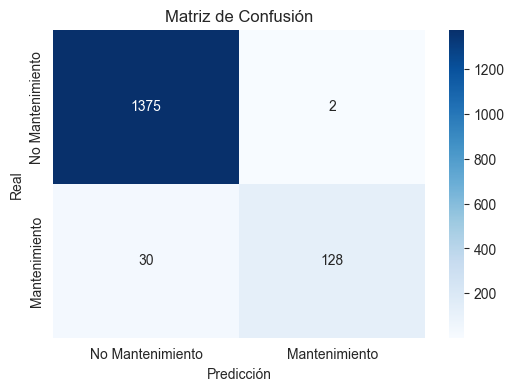

In [536]:
def train_validation(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convertir probabilidades en etiquetas binarias

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=["No Mantenimiento", "Mantenimiento"]))

    # Mostrar matriz de confusión con heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Mantenimiento", "Mantenimiento"],
                yticklabels=["No Mantenimiento", "Mantenimiento"])
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# Llama a la función con el modelo ya entrenado
train_validation(model, X_test, y_test)

Al igual que se visualizó con las gráficas, la matriz de confusión confirma lo afirmado, a continuación se realizará un ajuste de hiperparámetros mediante `RandomSearch` y `SMOTE` por el desbalanceo de clases

In [537]:
def build_model(hp):
 model = Sequential([
     Dense(units=hp.Int('units', min_value=32, max_value=512,step=32), activation='relu'),
     Dense(1, activation='sigmoid')
 ])
 model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp.Choice('learning_rate', [0.001, 0.01])),loss = 'mean_squared_error', metrics = ['mae'])
 return model

tuner = RandomSearch(
 build_model,
 objective='val_loss',
 max_trials=5,
 directory='./my_dir',
 project_name='prediccion'
)
tuner.search(X_train, y_train, validation_split=0.2)

Reloading Tuner from ./my_dir\prediccion\tuner0.json


In [538]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [539]:
best_model = tuner.hypermodel.build(best_hps)

In [540]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [541]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Ahora usa X_resampled, y_resampled en el entrenamiento
history = best_model.fit(X_resampled, y_resampled, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0884 - mae: 0.2097 - val_loss: 0.0287 - val_mae: 0.0831
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0348 - mae: 0.0740 - val_loss: 0.0230 - val_mae: 0.0567
Epoch 3/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0274 - mae: 0.0560 - val_loss: 0.0243 - val_mae: 0.0550
Epoch 4/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0271 - mae: 0.0514 - val_loss: 0.0284 - val_mae: 0.0584
Epoch 5/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0289 - mae: 0.0502 - val_loss: 0.0217 - val_mae: 0.0433
Epoch 6/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0300 - mae: 0.0512 - val_loss: 0.0198 - val_mae: 0.0399
Epoch 7/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0254 - mae: 0.0436 - val_loss: 0.0187 - val_mae: 0.0382
Epoch 8/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0287 - mae: 0.0468 - val_loss: 0.0106 - val_mae: 0.0205
Epoch 9/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Reporte de Clasificación:
                  precision    recall  f1-score   support

No Mantenimiento       0.97      0.97      0.97      5528
   Mantenimiento       0.97      0.97      0.97      5528

        accuracy                           0.97     11056
       macro avg       0.97      0.97      0.97     11056
    weighted avg       0.97      0.97      0.97     11056



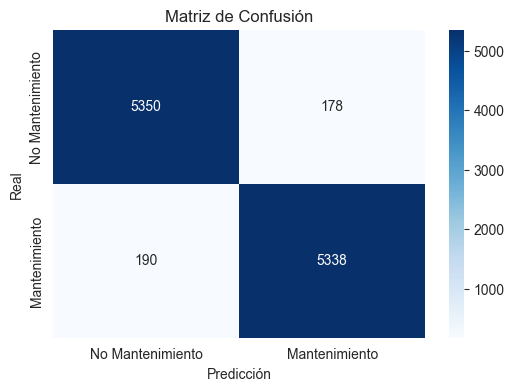

In [542]:
train_validation(best_model, X_resampled, y_resampled)

Ahora se puede apreciar una notoria mejoría con respecto al desempeño del modelo, donde se encuentra una precisión para la clase 0 del 0.99 y para la clase 1 una precisión del 0.94, así mismo, en la matriz de confusión se encuentra un número de falsos positivos bastante reducido en comparación con el resto de conclusiones

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0289 - mae: 0.0404
Pérdida: 0.039344120770692825, Precisión: 0.053835075348615646


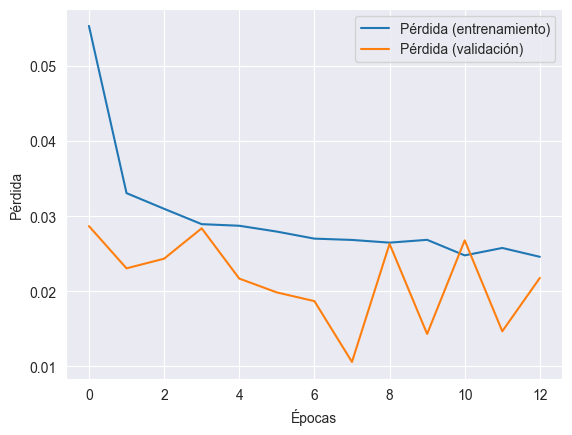

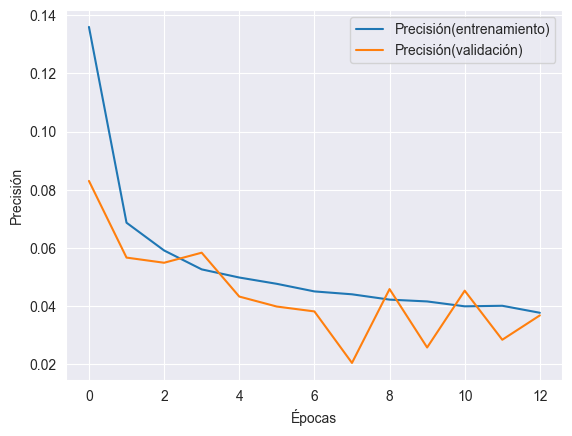

In [543]:
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Pérdida: {loss}, Precisión: {accuracy}")
# Pérdida
plt.plot(history.history['loss'], label='Pérdida (entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (validación)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
# Precisión
plt.plot(history.history['mae'], label='Precisión(entrenamiento)')
plt.plot(history.history['val_mae'], label='Precisión(validación)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()